###  Computing spectral analysis on the data to estimate pairwise coherence

The methods to compute the spectral analysis can be imported as follows:

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')

import time
import h5py
import scipy
import numpy                 as     np
import xarray                as     xr
import matplotlib.pyplot     as     plt
from frites.conn import define_windows

from   mne.cuda         import _smart_pad

from   GDa.session      import session
from   GDa.spectral_analysis.conn_coh import conn_coherence_wav, conn_coherence_psd

from   scipy.signal     import fftconvolve, coherence

from mne.time_frequency import tfr_array_morlet, tfr_array_multitaper

from frites.io      import set_log_level, logger
from frites.utils   import parallel_func
from frites.dataset import SubjectEphy
from frites.config  import CONFIG

### Loading data

In [2]:
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
              slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])
ses.read_from_mat()

### Morlet estimation

- band $1$  = [0.1,6]  Hz;
- band $2$  = [6,14]   Hz;
- band $3$  = [14,26]  Hz;
- band $4$  = [26,42]  Hz;
- band $5$  = [42,80]  Hz;

In [3]:
f_start, f_end, n_freqs, sfreq = .1, 80, 50, 1000
freqs = np.linspace(f_start, f_end, n_freqs, endpoint=True)
foi   = np.array([
            [0.1, 6.],
            [6., 14.],
            [14., 26.],
            [26., 42.],
            [42., 80.]
                ])

# define temporal windows + compute the DFC
n_cycles = freqs/2

kw = dict(
    freqs=freqs, times=ses.data.time, roi=ses.data.attrs['areas'], foi=foi, n_jobs=-1,
    sfreq=sfreq, mode='morlet', decim_at='tfd', n_cycles=n_cycles, decim=15,
    sm_times=300, sm_freqs=1, block_size=2
)

# compute the coherence
coh_morlet = conn_coherence_wav(ses.data.values.astype(np.float32), **kw)

Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   18.3s remaining:   26.6s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   21.1s remaining:   13.3s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   23.1s remaining:    5.2s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   24.9s finished


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   26.5s remaining:   38.4s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   28.0s remaining:   17.7s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   30.1s remaining:    6.8s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   32.1s finished


The auto spectra can be computed as tem elementwise product of $W$ and its conjugate:

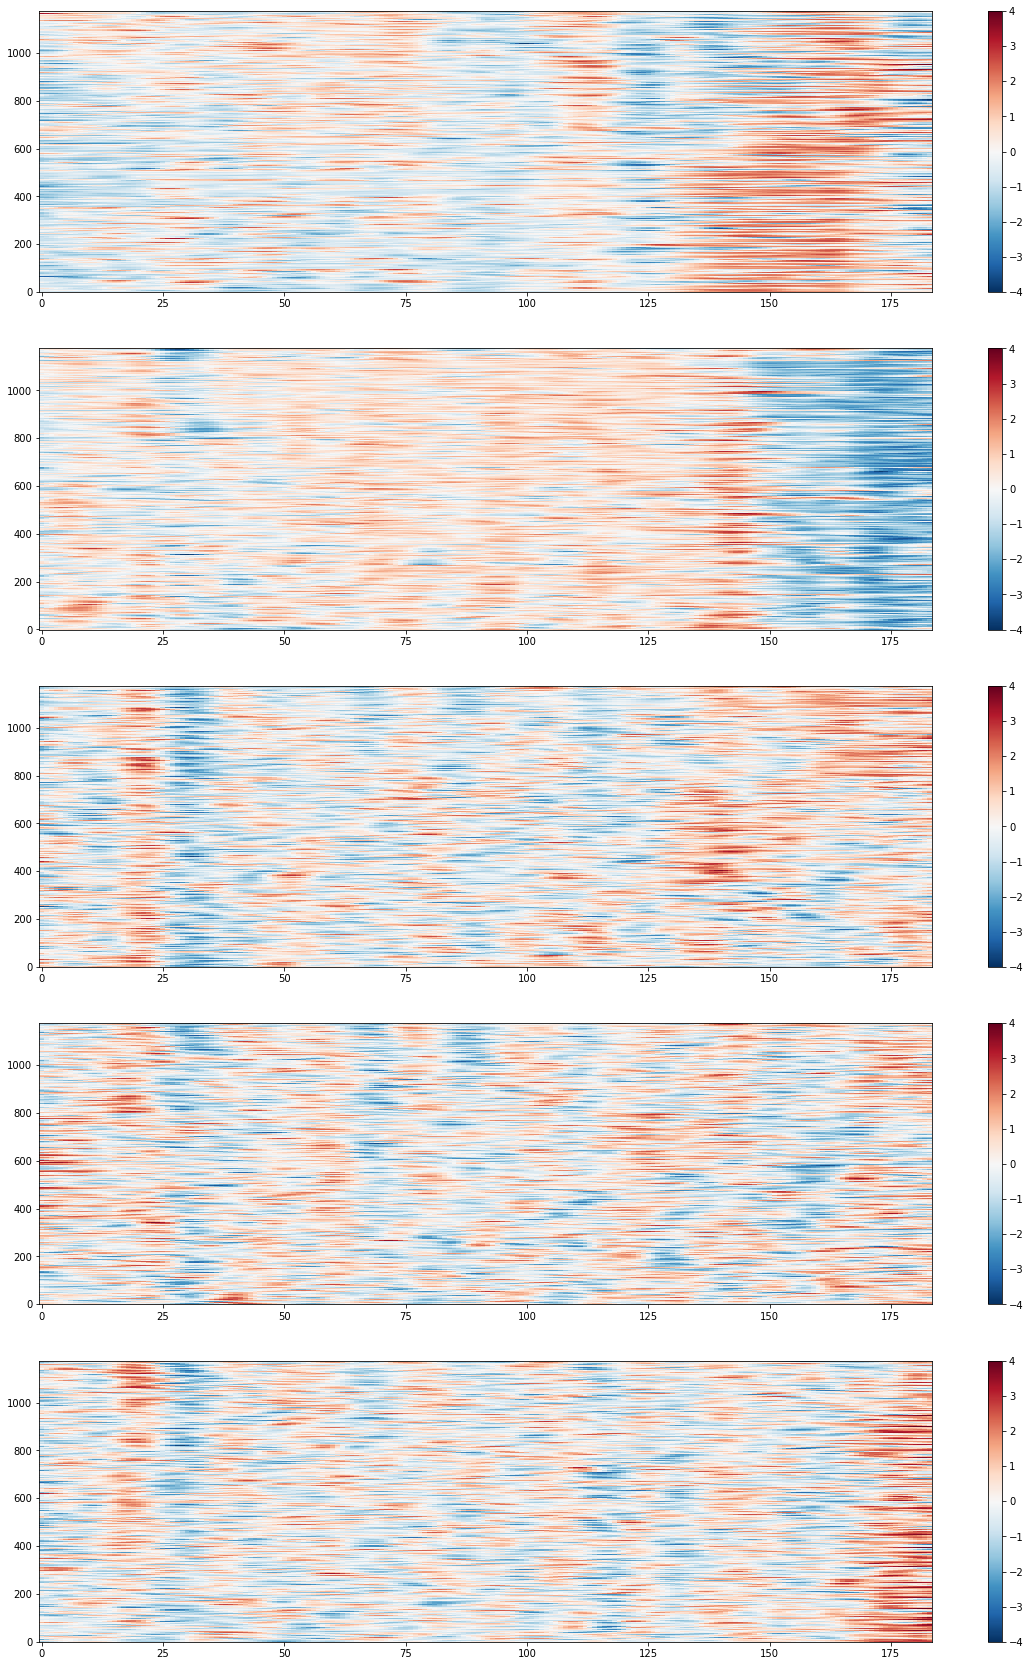

In [38]:
plt.figure(figsize=(20,30))
aux = coh_morlet.mean(dim='trials')[:,:,30:-30]
aux = (aux-aux.mean(dim='times'))/aux.std(dim='times')
for i in range(foi.shape[0]):
    plt.subplot(foi.shape[0],1,i+1)
    plt.imshow(aux.isel(freqs=i),aspect='auto', cmap='RdBu_r',origin='lower', vmin=-4, vmax=4)
    plt.colorbar()
plt.savefig('img/coh_morlet.png', dpi=300)  

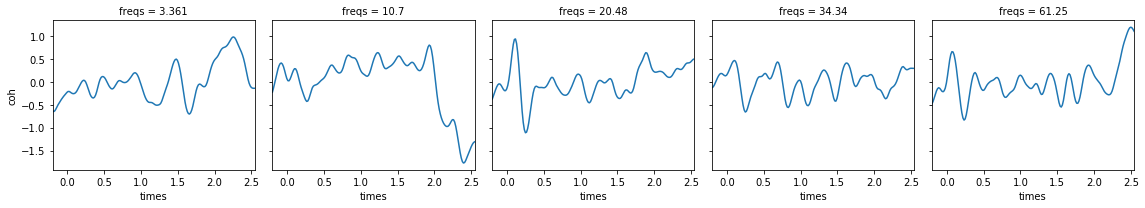

In [27]:
coh_morlet_mean = coh_morlet.mean(dim='trials')[:,:,30:-30]
coh_morlet_mean = (coh_morlet_mean-coh_morlet_mean.mean(dim='times'))/coh_morlet_mean.std(dim='times')
coh_morlet_mean.mean('roi').plot.line(x='times', col='freqs')
plt.xlim([coh_morlet_mean.times.min(), coh_morlet_mean.times.max()]);

### Multitaper estimation (method 1)

In [28]:
f_start, f_end, n_freqs, sfreq = .1, 80, 50, 1000
freqs = np.linspace(f_start, f_end, n_freqs, endpoint=True)
foi   = np.array([
            [0.1, 6.],
            [6., 14.],
            [14., 26.],
            [26., 42.],
            [42., 80.]
                ])

# define temporal windows + compute the DFC
n_cycles = freqs/2

kw = dict(
    freqs=freqs, times=ses.data.time, roi=ses.data.attrs['areas'], foi=foi, n_jobs=-1,
    sfreq=sfreq, mt_bandwidth=4.0, mode='multitaper', decim_at='tfd', n_cycles=n_cycles, decim=15,
    sm_times=300, sm_freqs=1, block_size=2
)

# compute the coherence
coh_mt = conn_coherence_wav(ses.data.values.astype(np.float32), **kw)

Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   48.3s remaining:  1.2min
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   50.9s remaining:   32.3s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   53.7s remaining:   12.1s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:  1.1min finished


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   56.5s remaining:  1.4min
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   58.1s remaining:   36.8s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   59.5s remaining:   13.4s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:  1.2min finished


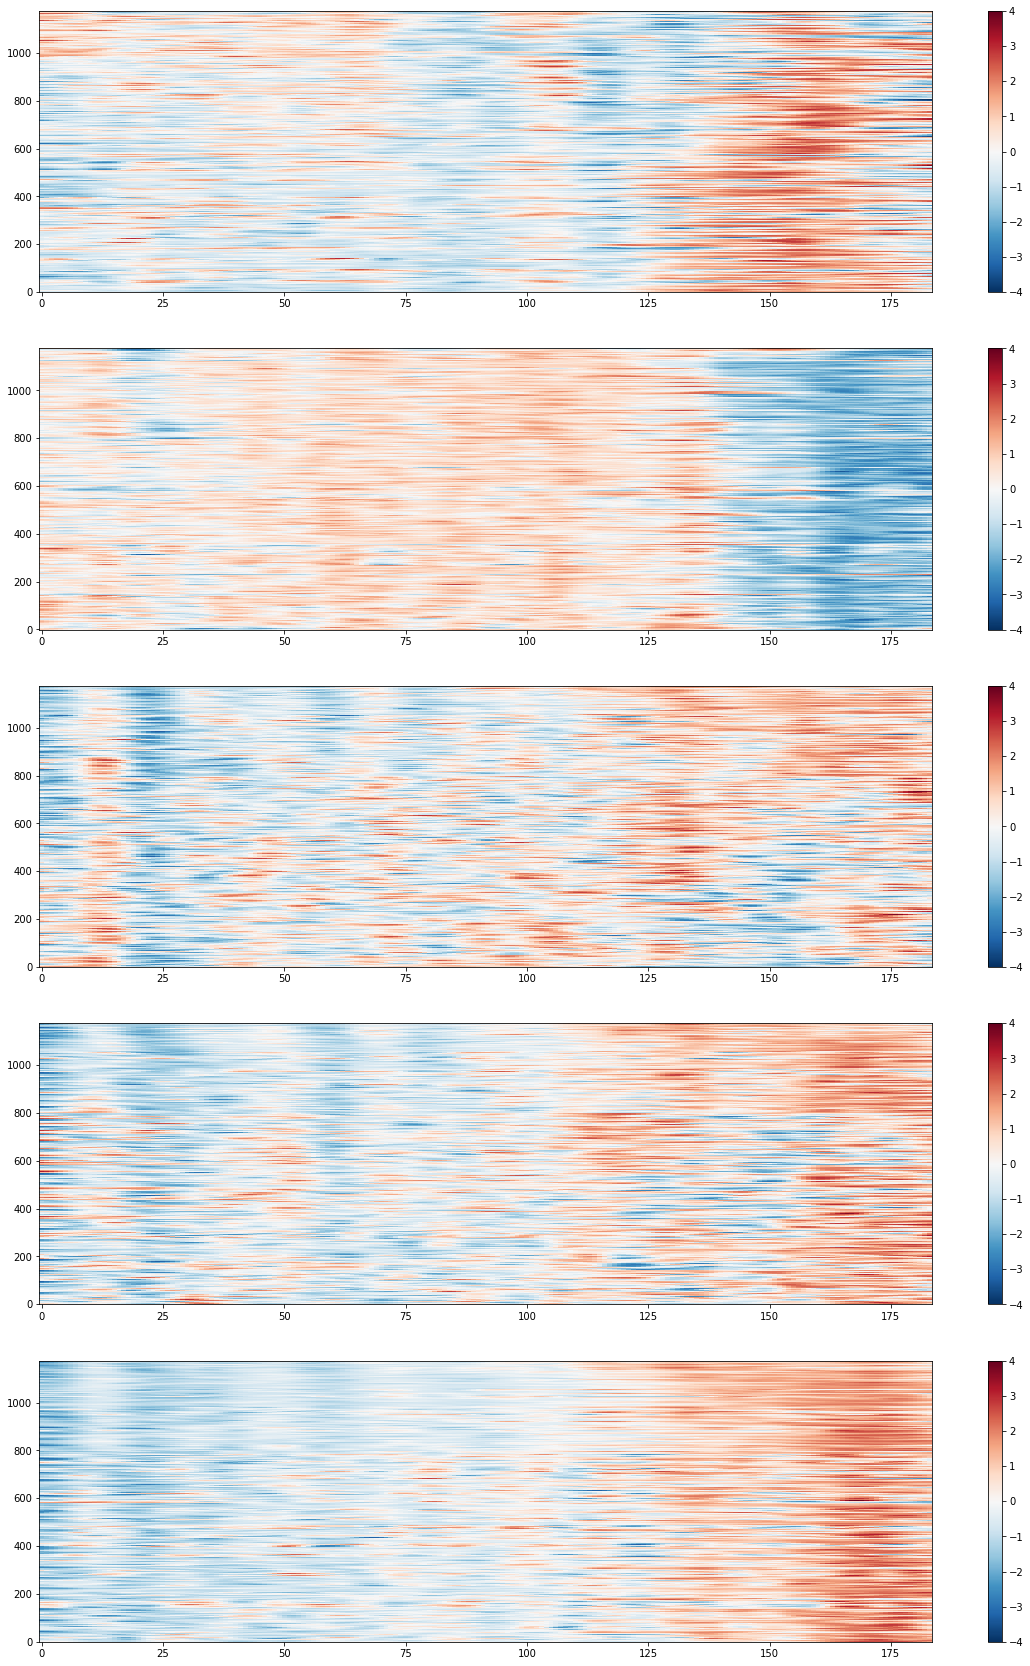

In [39]:
plt.figure(figsize=(20,30))
aux = coh_mt.mean(dim='trials')[:,:,30:-30]
aux = (aux-aux.mean(dim='times'))/aux.std(dim='times')
for i in range(foi.shape[0]):
    plt.subplot(foi.shape[0],1,i+1)
    plt.imshow(aux.isel(freqs=i),aspect='auto', cmap='RdBu_r',origin='lower', vmin=-4, vmax=4)
    plt.colorbar()  
plt.savefig('img/coh_mt.png', dpi=300)  

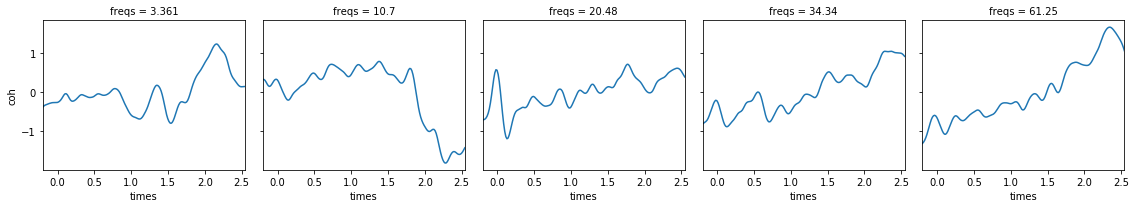

In [30]:
coh_mt_mean = coh_mt.mean(dim='trials')[:,:,30:-30]
coh_mt_mean = (coh_mt_mean-coh_mt_mean.mean(dim='times'))/coh_mt_mean.std(dim='times')
coh_mt_mean.mean('roi').plot.line(x='times', col='freqs')
plt.xlim([coh_mt_mean.times.min(), coh_mt_mean.times.max()]);

### Multitaper estimation (method 2)

In [31]:
sfreq = 1000
foi   = np.array([
            [0.1, 6.],
            [6., 14.],
            [14., 26.],
            [26., 42.],
            [42., 80.]
                ])


freqs        = foi.mean(axis=1)
W            = np.ceil( foi[:,1]-foi[:,0] )   # Bandwidth
mt_bandwidth = 8
# define temporal windows + compute the DFC
n_cycles     = mt_bandwidth * freqs / W  

kw = dict(
    freqs=freqs, times=ses.data.time, roi=ses.data.attrs['areas'], foi=None, n_jobs=-1,
    sfreq=sfreq, mt_bandwidth=mt_bandwidth, mode='multitaper', decim_at='tfd', n_cycles=n_cycles, decim=15,
    sm_times=300, sm_freqs=1, block_size=2
)

# compute the coherence
coh_mt2 = conn_coherence_wav(ses.data.values.astype(np.float32), **kw)

Compute pairwise coherence (n_pairs=1176, n_freqs=5, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   27.5s remaining:   39.9s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   27.8s remaining:   17.6s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   28.1s remaining:    6.3s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   32.3s finished


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   26.8s remaining:   38.8s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   27.0s remaining:   17.1s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   27.3s remaining:    6.1s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   31.6s finished


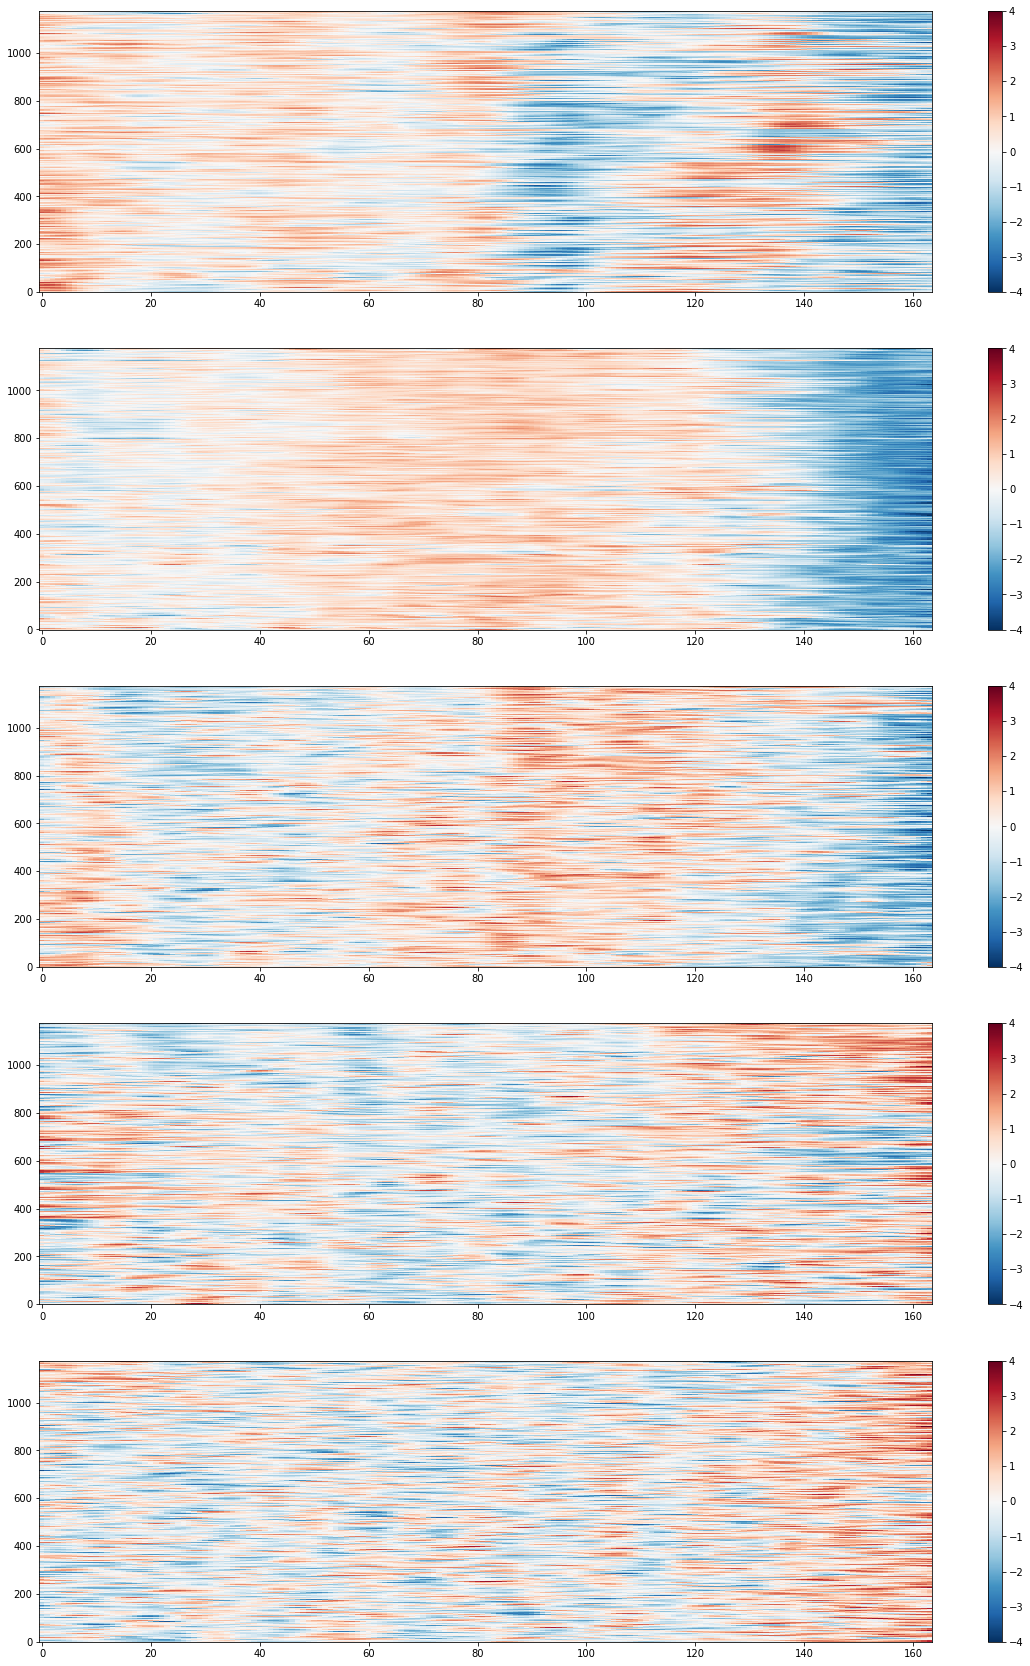

In [40]:
plt.figure(figsize=(20,30))
aux = coh_mt2.mean(dim='trials')[:,:,30:-50]
aux = (aux-aux.mean(dim='times'))/aux.std(dim='times')
for i in range(foi.shape[0]):
    plt.subplot(foi.shape[0],1,i+1)
    plt.imshow(aux.isel(freqs=i),aspect='auto', cmap='RdBu_r',origin='lower', vmin=-4, vmax=4)
    plt.colorbar()
plt.savefig('img/coh_mt2.png', dpi=300)

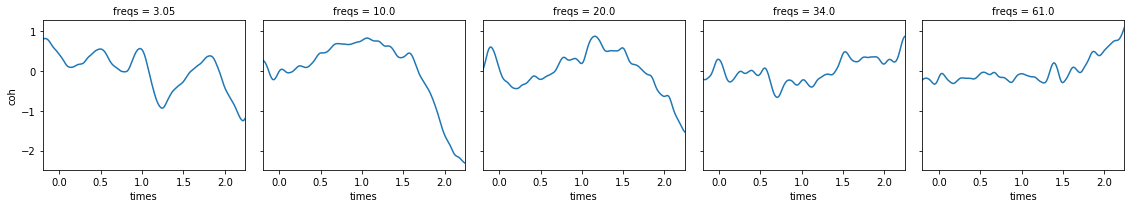

In [33]:
coh_mt2_mean = coh_mt2.mean(dim='trials')[:,:,30:-50]
coh_mt2_mean = (coh_mt2_mean-coh_mt2_mean.mean(dim='times'))/coh_mt2_mean.std(dim='times')
coh_mt2_mean.mean('roi').plot.line(x='times', col='freqs')
plt.xlim([coh_mt2_mean.times.min(), coh_mt2_mean.times.max()]);

### PSD estimation 

In [34]:
sfreq = 1000
foi   = np.array([
            [0.1, 6.],
            [6., 14.],
            [14., 26.],
            [26., 42.],
            [42., 80.]
                ])

win   = define_windows(ses.data.time.values, slwin_len=.5, slwin_step=.02)[0]
kw_coh=dict(nperseg=300, noverlap=250, nfft=500)

# compute the coherence
coh_psd = conn_coherence_psd(ses.data.values.astype(np.float32), 
                             times=ses.data.time, roi=ses.data.attrs['areas'], 
                             sfreq=sfreq, pairs=None, win_sample=win,
                             foi=foi, block_size=4, 
                             n_jobs=-1, kw_coh=kw_coh, verbose=None)

Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.65, stop=2.999000000000003, step=0.02)
    158 windows defined
Compute pairwise coherence (n_pairs=1176, n_windows=158)


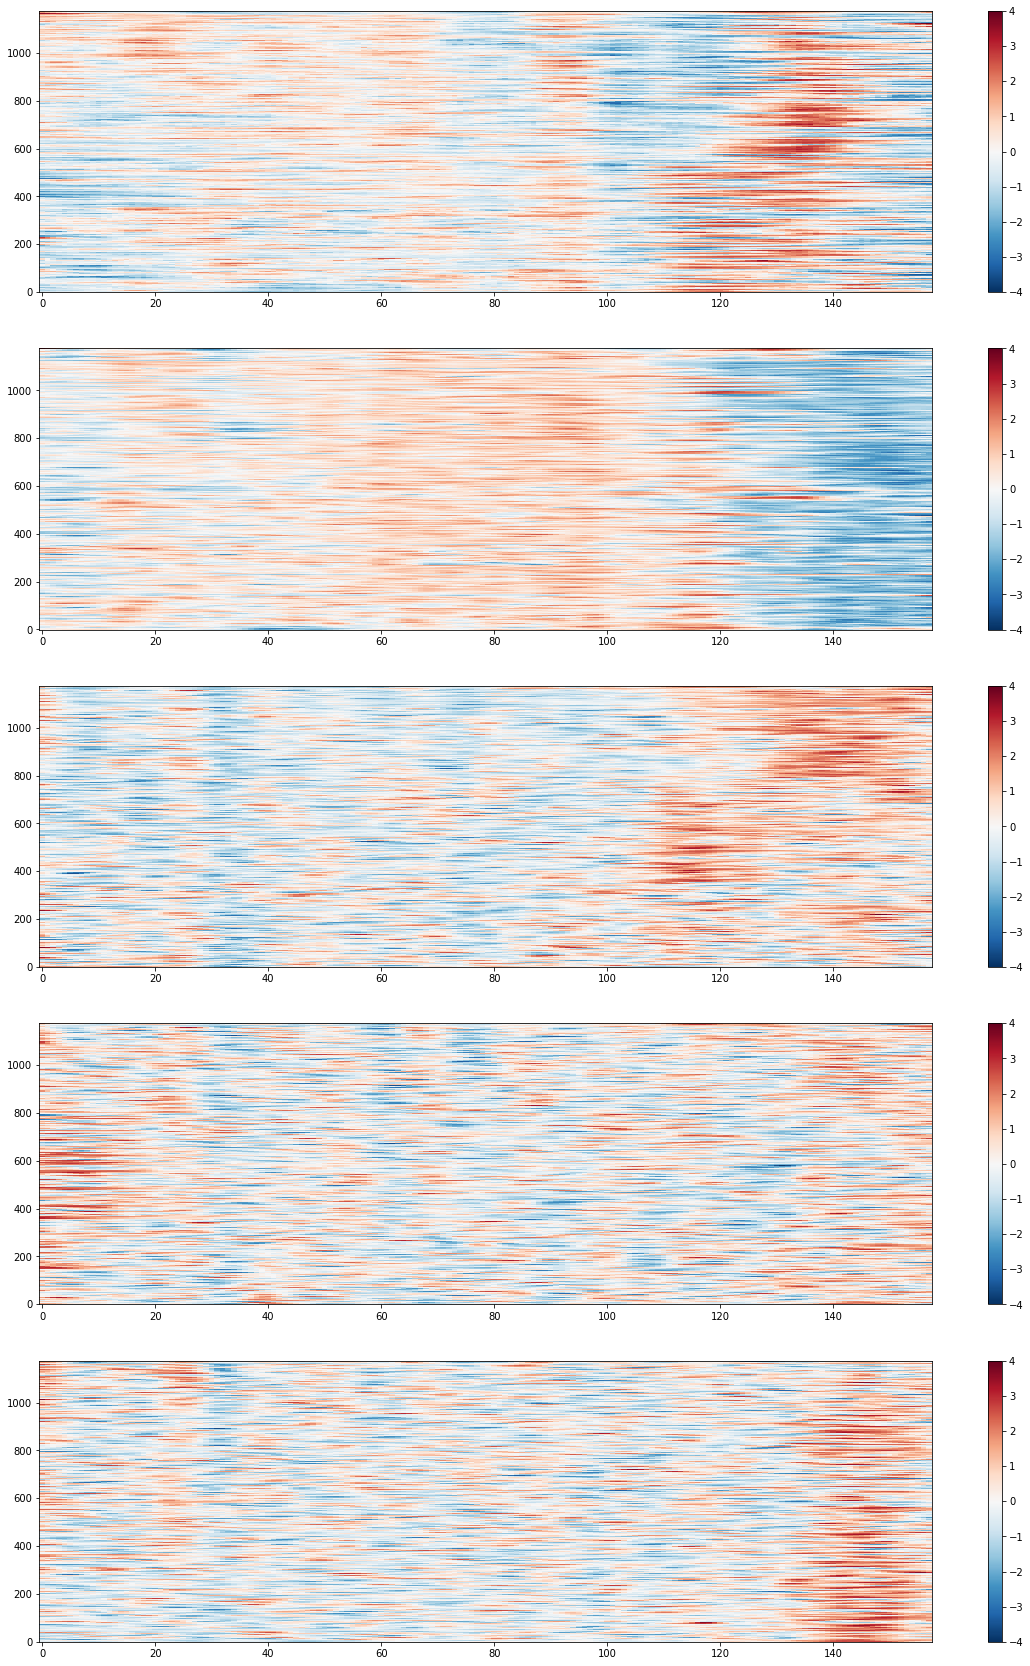

In [41]:
plt.figure(figsize=(20,30))
aux = coh_psd.mean(dim='trials')
aux = (aux-aux.mean(dim='times'))/aux.std(dim='times')
for i in range(foi.shape[0]):
    plt.subplot(foi.shape[0],1,i+1)
    plt.imshow(aux.isel(freqs=i),aspect='auto', cmap='RdBu_r',origin='lower', vmin=-4, vmax=4)
    plt.colorbar()
plt.savefig('img/coh_psd.png', dpi=300)

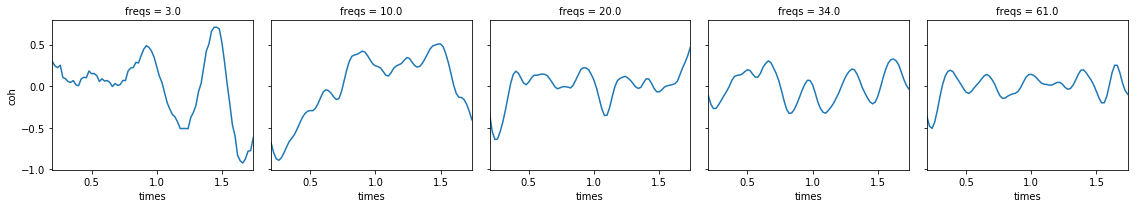

In [37]:
coh_psd_mean = coh_psd.mean(dim='trials')[:,:,30:-50]
coh_psd_mean = (coh_psd_mean-coh_psd_mean.mean(dim='times'))/coh_psd_mean.std(dim='times')
coh_psd_mean.mean('roi').plot.line(x='times', col='freqs')
plt.xlim([coh_psd_mean.times.min(), coh_psd_mean.times.max()]);